In [57]:
import swat
import os
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import lightgbm as lgb
import time
import gc
from sklearn.model_selection import train_test_split
from lightgbm import early_stopping
try:
    import cPickle as pickle
except BaseException:
    import pickle
import time

import sasctl.pzmm as pzmm
from sasctl import Session
from sasctl.services import model_repository as modelRepo
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from pathlib import Path
from sasctl.services import model_repository as mr
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
os.environ['CAS_CLIENT_SSL_CA_LIST'] = "C:/Users/turkak/SASVIYACERT/my_ca_certificate.pem"
hostname = 'https://server.demo.sas.com:443/cas-shared-default-http/'
username = 'sasdemo'
password = 'Orion123'
conn = swat.CAS('https://server.demo.sas.com:443/cas-shared-default-http/', username='sasdemo',password='Orion123')

In [3]:
conn.serverStatus()

NOTE: Grid node action status report: 1 nodes, 9 total actions executed.


[About]

 {'CAS': 'Cloud Analytic Services',
  'CASCacheLocation': 'CAS Disk Cache',
  'CASHostAccountRequired': 'OPTIONAL',
  'Copyright': 'Copyright © 2014-2022 SAS Institute Inc. All Rights Reserved.',
  'ServerTime': '2022-08-09T04:37:31Z',
  'System': {'Hostname': 'controller.sas-cas-server-default.sas-viya.svc.cluster.local',
   'Linux Distribution': 'Red Hat Enterprise Linux release 8.6 (Ootpa)',
   'Model Number': 'x86_64',
   'OS Family': 'LIN X64',
   'OS Name': 'Linux',
   'OS Release': '3.10.0-1160.6.1.el7.x86_64',
   'OS Version': '#1 SMP Tue Nov 17 13:59:11 UTC 2020'},
  'Transferred': 'NO',
  'Version': '4.00',
  'VersionLong': 'V.04.00M0P07182022',
  'Viya Release': '20220721.1658437616927',
  'Viya Version': 'Stable 2022.1.3',
  'license': {'expires': '22Oct2022:00:00:00',
   'gracePeriod': 45,
   'site': 'VIYA 4 W ESP, ACCESS, VA, VDMML, AIOT, AND PQA',
   'siteNum': 70180938,
   'warningPeriod': 49}}

[nodestatus]

 Node Status
 
                                                 name        role  uptime  running  stalled
 0  controller.sas-cas-server-default.sas-viya.svc...  controller   10.89        0        0

[server]

 Server Status
 
    nodes  actions
 0      1        9

+ Elapsed: 0.000879s, user: 0.000741s, sys: 0.000106s, mem: 0.322mb

In [4]:
if not os.path.exists('Models'):
    os.makedirs('Models')

In [ ]:
#tbl = conn.read_csv("./datasets/hmeq.csv",casout=dict(name='hmeq'))


#  Modelling Using SAS Cluster

In [5]:
#Load Required Actionset
Actionsetlist = ["sampling","FedSQL","lightgradboost"]
for act in range(len(Actionsetlist)):
    conn.loadactionset(Actionsetlist[act])

NOTE: Added action set 'sampling'.
NOTE: Added action set 'FedSQL'.
NOTE: Added action set 'lightgradboost'.


In [6]:
RawTable = 'HMEQ'
RawTablelib = 'casuser'
Target = "BAD"
OversamplingOutTable = RawTable + '_Out_Over'
PartitionedTable = RawTable + '_Part'

In [7]:
#Connect Data and assign
def AssignRawTable(table,library):
    tbl = conn.CASTable(name=RawTable,caslib=RawTablelib)
    return tbl
    

In [8]:
tbl = AssignRawTable(table=RawTable,library=RawTablelib) 

In [ ]:
#tbl.fetch(to=10)

In [ ]:
res = conn.simple.freq(                           # 1
    inputs = [{"name":"bad"}],                # 2
    table = {"name":"hmeq"},                   # 3
    casOut = {"name":"hmeq_freq",              # 4
              "replace":True})

res = conn.table.fetch(table = "hmeq_freq")       # 5
from IPython.core.display import display, HTML
display(res["Fetch"])

piedata = conn.CASTable(                          # 6
    "hmeq_freq").to_frame().sort_values(['_Frequency_'],
                                        ascending=False)



In [ ]:
'''import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (4.8, 3.6))
plt.title("Models Produced by Vehicle Type")
ax.pie(piedata._Frequency_, labels = piedata._Fmtvar_, 
       radius=1.1, autopct = "%.1f%%", pctdistance=0.75)
ax.get_figure()
'''

In [ ]:
#oversdict = dict(partind =True,eventprop = 0.3,event ="1",samppctevt=90)

In [9]:
def oversample(Table=RawTable,OverSamplingOut=OversamplingOutTable,**kwargs):
    
    DisplayDict = dict(names = "OVERFreq") 
    OverSamplingOutDict = dict(casout=dict(name=OverSamplingOut,replace=True),copyVars= "ALL")
    OverSamplingTableDict = dict(name = RawTable,groupBy = [Target]) # Oversampling works with groupBy Column -Target Field 
    OutputTablesDict = dict(names = "OVERFreq",replace = True)
    
    conn.oversample(display=DisplayDict,
                    output=OverSamplingOutDict,
                    partind=kwargs['partind'],
                    seed=10,
                    eventprop=kwargs['eventprop'],
                    event=kwargs['event'],
                    samppctevt=kwargs['samppctevt'],
                    table=OverSamplingTableDict,
                    outputTables=OutputTablesDict)
    
    over_out=conn.CASTable(OversamplingOutTable)
    return over_out

In [10]:
over_out = oversample(Table=RawTable,OverSamplingOut=OversamplingOutTable,partind=False,eventprop=0.3,event ="1",samppctevt=90)

NOTE: Oversampling is in effect.
NOTE: Using SEED=10 for sampling.
NOTE: The CAS table 'OVERFreq' in caslib 'CASUSER(sasdemo)' has 2 rows and 4 columns.


In [11]:
conn.CASTable('OVERFreq').fetch(to=10)

,ByGrpID,BAD,NObs,NSamp
0,0,0,4771,2497
1,1,1,1189,1070


In [12]:
# Partitioning the Data
def createpartition(samppct):
    PartitionedTable = RawTable + '_Part'
    hmeq_part = conn.CASTable(PartitionedTable, replace=True
                              #,computedVarsProgram = 'BAD_C = put(BAD,1.);' # (Create a new variable with program)
                             )
    
    over_out.groupby(Target).sampling.stratified(output=dict(casout=hmeq_part, copyvars='all'),
                                                 samppct=samppct,
                                                 partind=True
                                                )
    
    return hmeq_part

In [13]:
hmeq_part = createpartition(70) #pct of partition

NOTE: Stratified sampling is in effect.
NOTE: Using SEED=1229418715 for sampling.


In [14]:
Train = hmeq_part.query('_partind_ = 1')
Test = hmeq_part.query('_partind_ = 0')

In [15]:
feature_list = Train.columns.to_list()
vartypes = Train.dtypes
drop_cols = ['_Freq_','_PartInd_',Target]
feature_list = [x for x in feature_list if (x not in drop_cols )]

In [ ]:

#numeric_list = [x for x in feature_list if (vartypes == 'double')[x] == True]
#nominal_list = [x for x in Model_Inputs if (vartypes == 'double')[x] == False]
#Model_Inputs = numeric_list + nominal_list

In [17]:
def lgb_sas():
    numeric_list = [x for x in feature_list if (vartypes == 'double')[x] == True]
    nominal_list = [x for x in feature_list if (vartypes != 'double')[x] == True]
    Model_Inputs = numeric_list + nominal_list
    conn.lightgradboost.lgbmTrain(inputs=numeric_list,objective="BINARY",
        nominals=[Target],
        #nominals=nominal_list.append(Target),                      
        display= {'names':['IterHistory','ModelInfo','NObs']}  ,                
        output={'casout':{'name':'scored_train','replace':True}},
        savestate={'name':'lgb_ast','replace':True},
        seed=12345,
        table=Train,
        target=Target,
        validtable=Test,
        #outputTables={'names':['IterHistory_Train','ModelInfo','NObs'],'replace':True})
        outputTables = {"includeAll":True,"replace":True})

In [18]:
start_time = time.time()
lgb_sas()
print("--- %s seconds ---" % (time.time() - start_time))


NOTE: The misclassification error is     0.00.
NOTE: 345501 bytes were written to the table "lgb_ast" in the caslib "CASUSER(sasdemo)".
NOTE: The CAS table 'ModelInfo' in caslib 'CASUSER(sasdemo)' has 7 rows and 4 columns.
NOTE: The CAS table 'NObs' in caslib 'CASUSER(sasdemo)' has 4 rows and 3 columns.
NOTE: The CAS table 'IterHistory' in caslib 'CASUSER(sasdemo)' has 100 rows and 3 columns.
NOTE: lgbmTrain completed successfully.
--- 1.4910264015197754 seconds ---


In [19]:

lgb_train_scored =conn.CASTable('scored_train')

In [20]:
conn.loadactionset('aStore')

m=conn.describe(
   rstore='lgb_ast',
   epcode=True
)
print(m.Description)
print(m.InputVariables)
print(m.OutputVariables)
print(m.epcode)

NOTE: Added action set 'aStore'.
Basic Information

         Attribute               Value
0  Analytic Engine      lightGradBoost
1     Time Created  09Aug2022:04:51:26
Input Variables

      Name  Length Role Type RawType FormatName
0     LOAN     8.0   Id          Num           
1  MORTDUE     8.0   Id          Num           
2    VALUE     8.0   Id          Num           
3      YOJ     8.0   Id          Num           
4    DEROG     8.0   Id          Num           
5   DELINQ     8.0   Id          Num           
6    CLAGE     8.0   Id          Num           
7     NINQ     8.0   Id          Num           
8     CLNO     8.0   Id          Num           
9  DEBTINC     8.0   Id          Num           
Output Variables

     Name  Length       Type             Label
0   I_BAD    16.0  Character         Into: BAD
1  P_BAD0     8.0        Num  Predicted: BAD=0
2  P_BAD1     8.0        Num  Predicted: BAD=1
data sasep.out;
  dcl package score sc();
  dcl double "LOAN";
  dcl double "MOR

In [21]:
conn.CASTable('IterHistory').fetch(from_ =80 ,to=100)

,Number of Trees,Training Accuracy Metric,Validation Accuracy Metric
79,80,0.072731,0.256585
80,81,0.071724,0.256254
81,82,0.070583,0.255403
82,83,0.069379,0.255635
83,84,0.068252,0.255644
84,85,0.067054,0.256265
85,86,0.066090,0.256934
86,87,0.065063,0.257349
87,88,0.064078,0.256759
88,89,0.062925,0.256793


In [34]:
lgb_test_scored = conn.CASTable('lgb_score_out',replace = True)
conn.score(
   table=Test,
   casout={'name':'lgb_score_out','replace':True},
   rstore='lgb_ast'
)
m=lgb_test_scored.fetch(to=10)

In [39]:
m

,I_BAD,P_BAD0,P_BAD1
0,1,0.004857,0.995143
1,1,0.045953,0.954047
2,1,0.026204,0.973796
3,1,0.002927,0.997073
4,1,0.002184,0.997816
5,1,0.005219,0.994781
6,1,0.020552,0.979448
7,1,0.011586,0.988414
8,1,0.007971,0.992029
9,1,0.049745,0.950255


In [46]:
p_target_1 = 'P_'+ Target +'1'
p_target_0 = 'P_'+ Target +'0'
resp = 'I_' + Target

In [41]:
p_target_1

'P_BAD1'

In [ ]:
#conn.close()

In [48]:
lgb_assess = conn.percentile.assess(
            table=lgb_test_scored,
            inputs=[p_target_1],      
            response=resp,
            event='1',
            pvar=[p_target_0],
            pevent=['0']      
        )

gb_fitstat  = lgb_assess.FitStat
gb_rocinfo  = lgb_assess.ROCInfo
gb_liftinfo = lgb_assess.LIFTInfo


In [55]:
# Add new variable to indicate type of model
gb_liftinfo['model']   = 'lgb_model'
gb_rocinfo['model']    = 'lgb_model'

# # Concatenate data
#all_liftinfo = pd.concat([rf_liftinfo, gb_liftinfo, nn_liftinfo, tree_liftinfo], ignore_index=True)
#all_rocinfo = pd.concat([rf_rocinfo, gb_rocinfo, nn_rocinfo, tree_rocinfo], ignore_index=True)

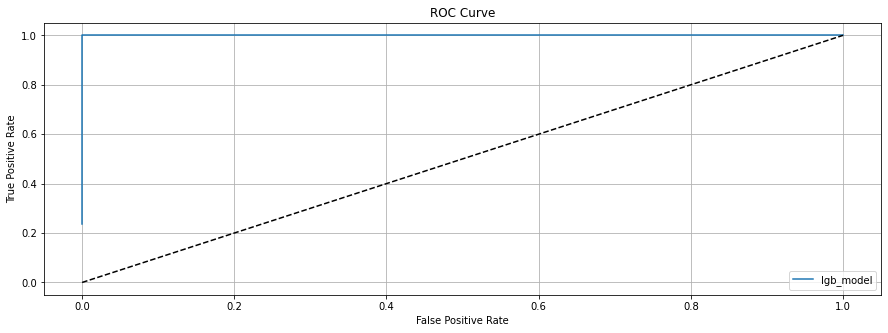

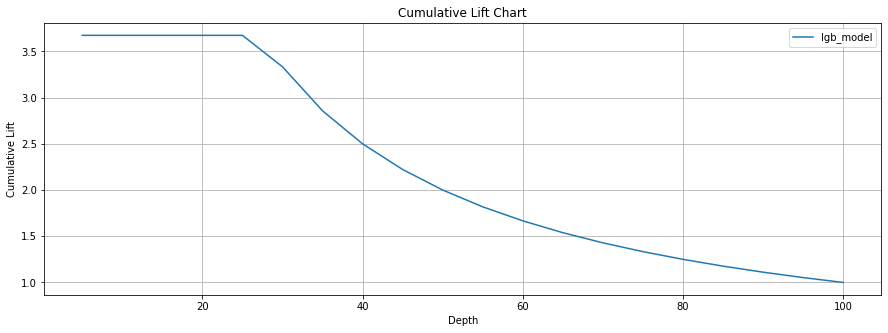

In [58]:
# Draw ROC charts 
plt.figure(figsize=(15, 5))
for key, grp in gb_rocinfo.groupby(['model']):
    plt.plot(grp['FPR'], grp['Sensitivity'], label=key)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend(loc='best')
plt.title('ROC Curve')
plt.show()

# Draw lift charts
plt.figure(figsize=(15, 5))
for key, grp in gb_liftinfo.groupby(['model']):
    plt.plot(grp['Depth'], grp['CumLift'], label=key)
plt.xlabel('Depth')
plt.ylabel('Cumulative Lift')
plt.grid(True)
plt.legend(loc='best')
plt.title('Cumulative Lift Chart')
plt.show();